In [1]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Activation, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
##### convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
data = pd.read_csv('modified_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22303554 entries, 0 to 22303553
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   ORIGIN               object 
 3   DEST                 object 
 4   CRS_DEP_TIME         object 
 5   DEP_DELAY            float64
 6   ARR_DELAY            float64
 7   AIR_TIME             float64
 8   DISTANCE             float64
 9   CARRIER_DELAY        float64
 10  WEATHER_DELAY        float64
 11  NAS_DELAY            float64
 12  SECURITY_DELAY       float64
 13  LATE_AIRCRAFT_DELAY  float64
 14  year                 int64  
 15  month                int64  
 16  day                  int64  
 17  origin               object 
 18  destination          object 
 19  planned departure    float64
dtypes: float64(10), int64(3), object(7)
memory usage: 3.3+ GB


In [5]:
southwest = data[data['OP_CARRIER'] == 'Southwest Airlines']

In [6]:
sw_delay = southwest.groupby(['year', 'month'])[['DEP_DELAY']].sum()

In [7]:
##### count number of flights per day
sw_count = southwest.groupby(['year', 'month'])[['DEP_DELAY']].count()

In [8]:
##### averaged delayed time per late flight departure
sw = sw_delay/sw_count
sw

DEP_DELAY
year month           
2009 1      20.212932
     2      17.453698
     3      20.054456
     4      20.601174
     5      19.964056
...               ...
2018 8      27.714130
     9      23.421262
     10     22.115006
     11     23.451521
     12     25.342073

[118 rows x 1 columns]

In [9]:
##### normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(sw)

#### split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train))
#print(len(test))

##### reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

##### reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

##### create and fit the LSTM network
batch_size = 2

early_stopping = EarlyStopping(monitor='val_mse', patience=25)
score=[]
for i in range(5):
    ##### build model
    model = Sequential()
    model.add(Bidirectional(LSTM(16, batch_input_shape=(batch_size, look_back, 1), return_sequences=True)))
    model.add(Bidirectional(LSTM(16, activation='tanh', return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    ##### compile model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    ##### fit model
    history = model.fit(trainX, trainY, epochs=200, batch_size=batch_size, validation_data=(testX, testY), verbose=2, shuffle=False, callbacks=[early_stopping])

    ##### make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)

    ##### invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    y_pred_train = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    y_pred_test = scaler.inverse_transform([testY])

    ##### calculate root mean squared error
    temp =[]
    trainScore = math.sqrt(mean_squared_error(y_pred_train[0], trainPredict[:,0]))
    print('Train RMSE: %.4f' % (trainScore))
    MAPE_train = mean_absolute_percentage_error(y_pred_train[0], trainPredict[:,0])*100
    print('Train MAPE: %.4f' % (MAPE_train))

    testScore = math.sqrt(mean_squared_error(y_pred_test[0], testPredict[:,0]))
    print('Test RMSE: %.4f' % (testScore))
    MAPE_test = mean_absolute_percentage_error(y_pred_test[0], testPredict[:,0])*100
    print('Test MAPE: %.4f' % (MAPE_test))
    
    temp.append(trainScore)
    temp.append(MAPE_train)
    temp.append(testScore)
    temp.append(MAPE_test)
    score.append(temp)

Train on 81 samples, validate on 11 samples
Epoch 1/200
81/81 - 9s - loss: 0.1058 - mse: 0.1058 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 2/200
81/81 - 1s - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 3/200
81/81 - 1s - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 4/200
81/81 - 1s - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 5/200
81/81 - 1s - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 6/200
81/81 - 1s - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 7/200
81/81 - 1s - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 8/200
81/81 - 1s - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 9/200
81/81 - 1s - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 10/200
81/81 - 1s - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 11/200
81/81 - 1s - loss: 0.0377 - mse: 0.0377 - val_loss: 

In [10]:
score

[[3.0993869823933906,
  10.813187908062755,
  1.6762343569073055,
  5.589913114290748],
 [3.1455785495970696,
  11.023146284809044,
  1.6591497062372722,
  5.449366419349877],
 [3.1114624620920592,
  10.894692785756682,
  1.6572687361190028,
  5.503572034372162],
 [3.1625260716382693,
  10.824215190387825,
  1.5079337704109983,
  5.425596452831647],
 [3.153572163428867, 11.179381064751013, 1.750413903521624, 5.836911901763748]]

[ 3.13450525 10.94692465  1.65020009  5.56107198]
[0.02463978 0.13821506 0.07885475 0.14903521]


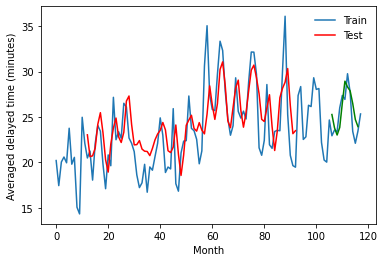

In [11]:
##### average RMSE and MAPE
print(np.mean(score, axis = 0))
print(np.std(score, axis = 0))
    
##### shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

##### shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

##### plot baseline and predictions
fig, ax = plt.subplots()
ax.plot(scaler.inverse_transform(dataset))
ax.plot(trainPredictPlot, color='red')
ax.plot(testPredictPlot, color='green')
ax.set_xlabel('Month')
ax.set_ylabel('Averaged delayed time (minutes)')
plt.legend(['Train', 'Test'], frameon=False)
plt.show()
fig.savefig('sw_revised.png')

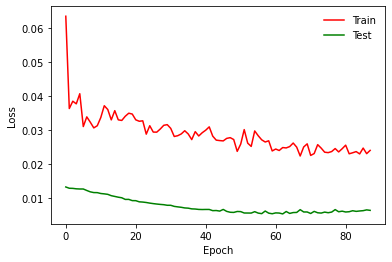

In [12]:
##### graph MSE
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='red')
ax.plot(history.history['val_loss'], color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(['Train', 'Test'], frameon=False)
plt.show()
fig.savefig('sw_mse.png')